In [1]:
! pip install transformers datasets
!pip install evaluate
!pip install jiwer
!pip install accelerate -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [1]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/pokemon-blip-captions")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

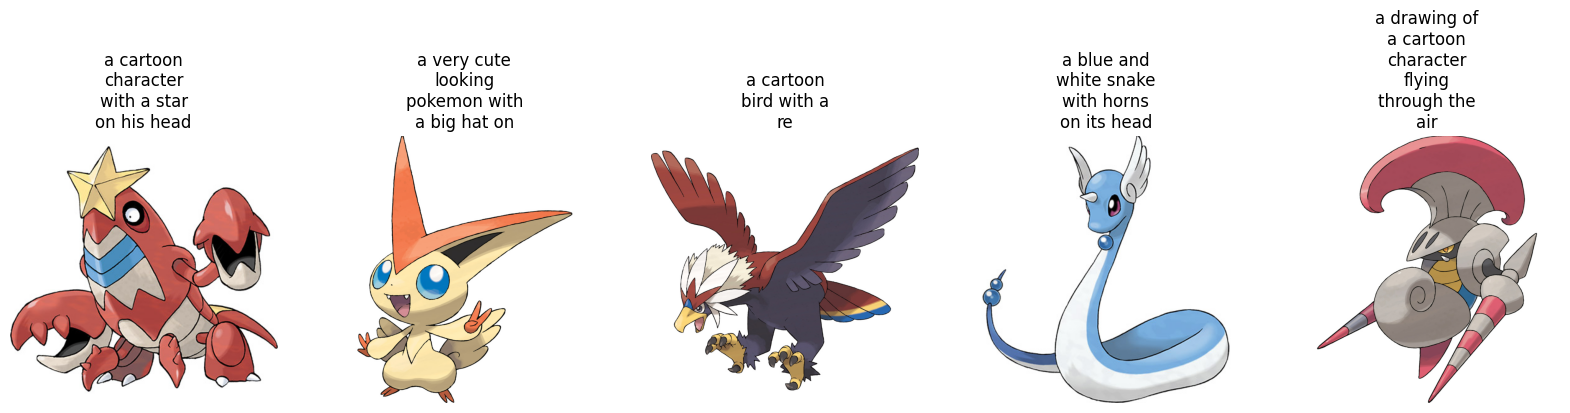

In [4]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

images = [np.array(train_ds[i]["image"]) for i in range(5)]
captions = [train_ds[i]["text"] for i in range(5)]

plt.figure(figsize=(20, 20))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    caption = captions[i]
    caption = "\n".join(wrap(caption, 12))
    plt.title(caption)
    plt.imshow(images[i])
    plt.axis("off")

In [5]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [6]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [7]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [8]:
from evaluate import load
import torch

wer = load("wer")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [9]:
checkpoint

'microsoft/git-base'

In [10]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=1,
    fp16=True,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
)

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=134, training_loss=5.041516204378498, metrics={'train_runtime': 88.3023, 'train_samples_per_second': 7.542, 'train_steps_per_second': 1.518, 'total_flos': 311476636790784.0, 'train_loss': 5.041516204378498, 'epoch': 1.0})

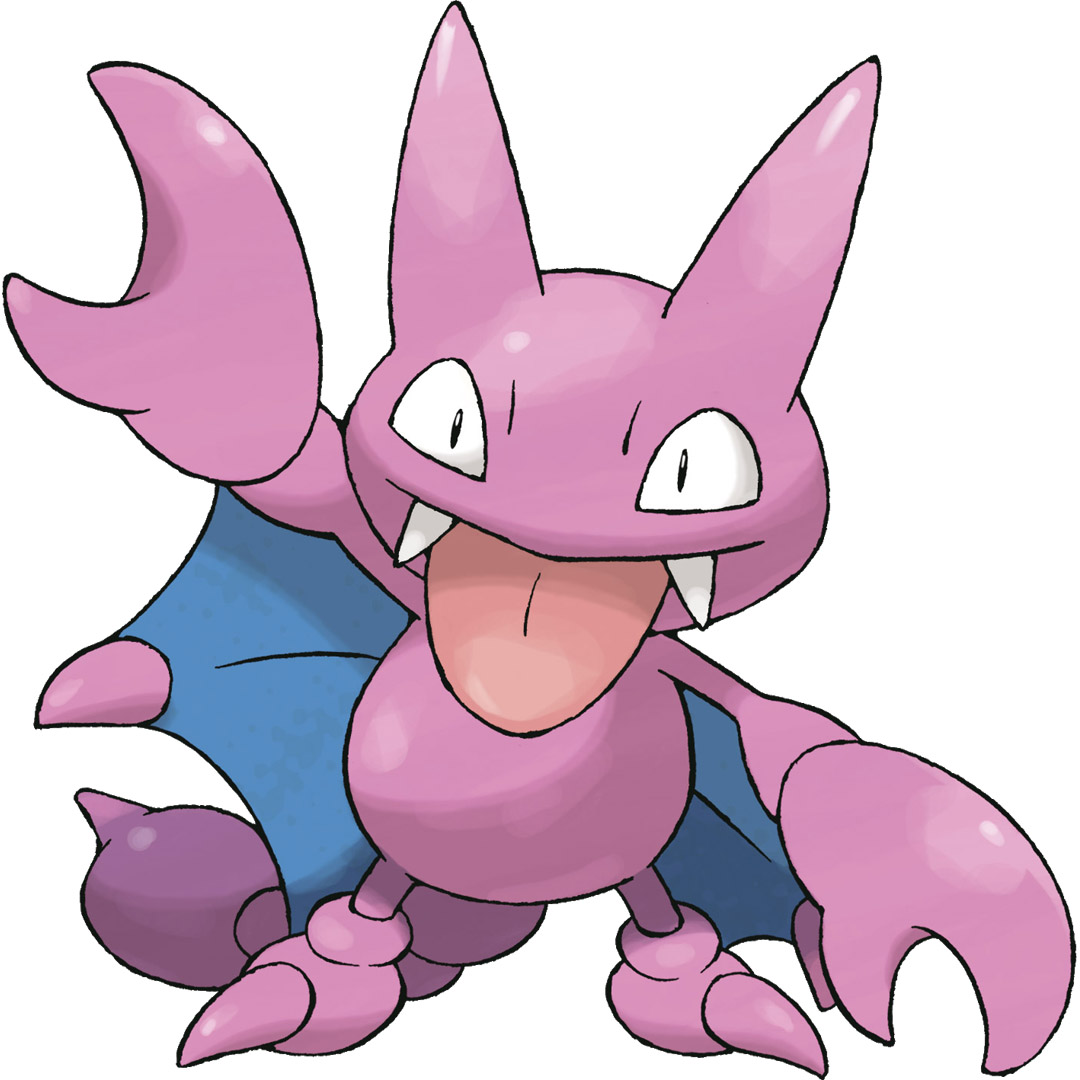

In [13]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [15]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a drawing of a cartoon character with a pink nose


In [16]:
generated_ids

tensor([[ 101, 1037, 5059, 1997, 1037, 9476, 2839, 2007, 1037, 5061, 4451,  102]],
       device='cuda:0')